# Self-Reflection
A technique where an LLM is prompted to review, critique, or verify its own initial response, often leading to a revised, improved answer. This is a form of meta-reasoning where the model acts as its own "critic."

Key Mechanism:

- Generate an initial answer.
- Reflect on potential errors, omissions, or reasoning flaws.
- Refine the answer based on self-feedback.

Use Cases:

- Improving accuracy in complex QA, code generation, or planning tasks.
- Detecting and reducing hallucinations, logical inconsistencies, or alignment issues.
- Often used with Chain-of-Thought (CoT) to re-check reasoning steps.

Advantages:

- Low-cost way to boost performance without extra training or retrieval.
- Can catch simple mistakes the first pass missed.
- Enhances explainability by revealing the model's internal critique.

Disadvantages:

- Limited by the model's own knowledge and self-awareness — cannot correct fundamental knowledge gaps.
- Can lead to "overthinking" or excessive refinement without real improvement.
- May introduce new errors during the reflection stage if the critique is flawed.

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain.tools import tool
from langchain_classic.prompts import PromptTemplate
from langchain_core.tools.retriever import create_retriever_tool
from pydantic import BaseModel,Field
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from typing import TypedDict, Literal, Annotated, Sequence
from langchain.agents import create_agent
from langgraph.graph.message import add_messages, BaseMessage
from IPython.display import Image, display
from langchain_groq import ChatGroq
from typing import List
from langgraph.prebuilt import tools_condition,ToolNode
from dotenv import load_dotenv
from langchain_classic import hub
import os
load_dotenv()

False

In [2]:
! pip install pandas openpyxl langchain-groq langchain==1.2 faiss-cpu langchain-community sentence-transformers pymupdf langchain-huggingface langchain-text-splitters python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 56.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 62.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.1
    Uninstalling langchain-core-1.2.1:
      Successfully uninstalled langchain-core-1

In [4]:
# CEO & Blog
urls = ["https://parspack.com/blog/online-business/what-is-blog",
        "https://parspack.com/blog/online-business/seo-tutorial/what-is-keyword-mapping"]
docs = []
for url in urls:
    loader = WebBaseLoader(url)
    docs.extend(loader.load())

In [5]:
# normalizer
import re

def normalize_persian(text: str) -> str:
    text = text.replace("ي", "ی").replace("ك", "ک")
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [6]:
# docs = [item for sublist in loaders for item in sublist]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=80,separators=["\n\n", "\n", ".", "؟", " "])
texts = text_splitter.split_documents(docs)
for doc in texts:
    doc.page_content = normalize_persian(doc.page_content)
embedding_model = HuggingFaceEmbeddings(model_name="HooshvareLab/bert-base-parsbert-uncased")
vectorstore = FAISS.from_documents(texts, embedding_model)
retriever = vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={"k":3})

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

### Graph making

In [9]:
class ReflectState(BaseModel):
    question: str
    answer :str =""
    docs: List[Document] = []
    reflection:str= ""
    revised : bool = False
    attempt :int =0
    

### Nodes

In [47]:
# Retriever
def retrieve(state:ReflectState)-> ReflectState:
    print("we are in retrieve node\n")
    docs = retriever.invoke(state.question)
    print(f"docs : {docs}\n")
    return state.model_copy(update={"docs": docs})

In [44]:
# Generator
def generator (state:ReflectState)-> ReflectState:
    print("we are in generator node\n")
    context = "\n\n".join([doc.page_content for doc in state.docs])
    print(f"docs : {context}\n")
    prompt = """
    برای پاسخ به خواسته کاربر از اطلاعات زیر استفاده کن
    اطلاعات : {context}
    خواسته کاربر : {state.question}
    """
    result = llm.invoke(prompt).content.strip()
    print(f"the llm result {state.attempt} is {result}\n")
    return state.model_copy(update={"answer":result, "attempt" : state.attempt + 1})

In [30]:
# Self-Reflect
def reflect_on_answer(state: ReflectState) -> ReflectState:
    
    prompt = f"""
   (self reflection prompt)
روی پاسخ زیر فکر کن تا متوجه بشوی آیا به طور کامل به سوال پاسخ داده شده است یا خیر.

اگر کامل و صحیح است، بله و اگر نه را با توضیح بیان کنید.

خواسته کاربر: {state.question}

پاسخ : {state.answer}

مانند نمونه زیر پاسخ بده:
Reflection: YES or NO
توضیحات: ...
"""
    result = llm.invoke(prompt).content
    is_ok = "reflection: yes" in result.lower()
    return state.model_copy(update={"reflection": result, "revised": not is_ok})

In [35]:
# decider
def decider(state: ReflectState) -> ReflectState:
    if not state.revised or state.attempt >= 2:
        "done"
    else:
        "retriever"

In [32]:
# Finalizer
def finalize(state: ReflectState) -> ReflectState:
    return state

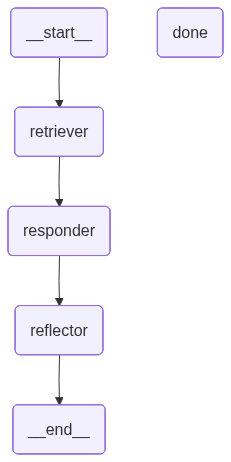

In [48]:
# Graph-design
builder = StateGraph(ReflectState)

builder.add_node("retriever", retrieve)
builder.add_node("responder", generator)
builder.add_node("reflector", reflect_on_answer)
builder.add_node("done", finalize)

builder.set_entry_point("retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", "reflector")
builder.add_conditional_edges(
    "reflector",
    decider
)
builder.add_edge("done", END)
graph = builder.compile()
graph

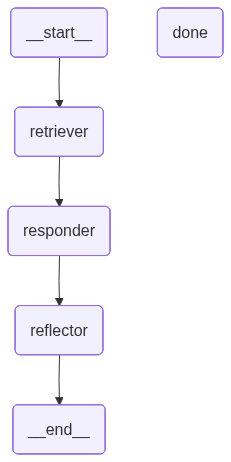

In [52]:
# -------------------------
# 4. LangGraph DAG
# -------------------------
builder = StateGraph(ReflectState)

builder.add_node("retriever", retrieve)
builder.add_node("responder", generator)
builder.add_node("reflector", reflect_on_answer)
builder.add_node("done", finalize)

builder.set_entry_point("retriever")

builder.add_edge("retriever", "responder")
builder.add_edge("responder", "reflector")
builder.add_conditional_edges(
    "reflector",
    lambda s: "done" if not s.revised or s.attempt >= 3 else "retriever"
)

graph = builder.compile()
graph

In [53]:
if __name__ == "__main__":
    user_query = "چطور احتمال کلیک روی سایت خود را افزایش دهیم"
    init_state = ReflectState(question=user_query)
    result = graph.invoke(init_state)

    print("\nFinal Answer:\n", result["answer"])
    print("\nReflection Log:\n", result["reflection"])
    print("Total Attempts:", result["attempt"])

we are in retrieve node

docs : [Document(id='2bfc8c43-77e5-406e-88d5-152e6a466a14', metadata={'source': 'https://parspack.com/blog/online-business/seo-tutorial/what-is-keyword-mapping', 'title': 'کیورد مپینگ (keyword mapping) چیست و چه کاربردی دارد؟ - پارس پک', 'description': 'کیورد مپینگ (Keyword Mapping) یک استراتژی کلیدی در سئو است. برای برای آشنایی با کیورد مپینگ و کاربرد آن در سئو این مقاله را مطالعه کنید.', 'language': 'fa-IR'}, page_content='صفحه مربوط به لپ تاپ را برای خرید لپ تاپ گیمینگ صفحه مربوط به گوشی موبایل را برای بهترین قیمت گوشی هوشمند صفحه مربوط به تبلت را برای راهنمای خرید تبلت دانشجوی با اعمال کیورد مپینگ محصول موتورهای جست وجو متوجه می شوند هر صفحه برای چه کلمه ای باید رتبه بگیرد این مسئله شانس شما را برای کسب رتبه های برتر گوگل افزایش می دهد برای آشنایی بیشتر با کلمات کلیدی و نحوه انتخاب آن ها مقاله زیر را مطالعه کنید کلمه کلیدی چیست'), Document(id='1d5fd0cc-ba07-4631-9f74-e6bb5fd8a06f', metadata={'source': 'https://parspack.com/blog/online-business/seo-tutorial/

### In this case we force the model to retreive the docs again if contexts was not relevant to the query so:
**model stay in a loop with unmatched contexts**

**Solution :**
- try to change the query base on retrieved docs with alarming the user
- iterate this reseaning+recflectio (ReAct) to get the best response according to our context

In [14]:
class RState(BaseModel):
    question: str
    answer :str =""
    docs: List[Document] = []
    Rquestion:str= ""
    revised : bool = False
    attempt :int =0

In [15]:
# Retriever
def retrieve (state:RState)->Rstate:
    query = state.question or state.Rquestion
    print(f"question : {state.question} Rquestion : {state.Rquestion}\n")
    docs = retriever.invoke(query)
    return state.model_copy(update={"docs": docs})

In [22]:
# Generator
def generator (state:RState)-> RState:
    context = "\n\n".join([doc.page_content for doc in state.docs])
    print(f"docs : {context}\n")
    prompt = f"""
    برای پاسخ به خواسته کاربر از اطلاعات زیر استفاده کن
    اطلاعات : {context}
    خواسته کاربر : {state.question}
    """
    result = llm.invoke(prompt).content.strip()
    print(f"the llm result {state.attempt} is {result}\n")
    return state.model_copy(update={"answer":result, "attempt" : state.attempt + 1})

In [68]:
# Reflect
def Reflect (state:RState)-> RState:
    prompt = f"""
   Evaluate whether the answer below is factually sufficient and complete.

    Question: {state.question}
    Answer: {state.answer}

    Respond 'YES' if it's complete, otherwise 'NO' with feedback.
    no more response.
    """
    
    feedback = llm.invoke(prompt).content.lower()
    
    verified = "yes" in feedback
    print(f"\n{feedback} and {verified}\n")
    return state.model_copy(update={"revised": verified})

In [69]:
# Refine
def Refine (state:RState)-> RState:
    print(f"we are in Refine node\n")
    prompt = f"""
   The answer appears incomplete. Suggest a better version of the query that would help retrieve more relevant context.

Original Question: {state.question}
Current Answer: {state.answer}
    """
    new_query = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"Rquestion": new_query})

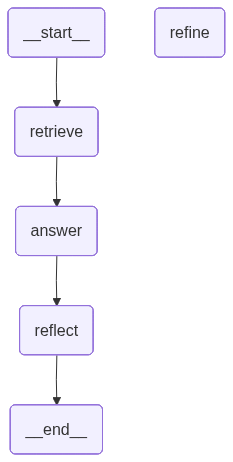

In [70]:
builder = StateGraph(RState)

builder.add_node("retrieve", retrieve)
builder.add_node("answer", generator)
builder.add_node("reflect", Reflect)
builder.add_node("refine", Refine)

builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "answer")
builder.add_edge("answer", "reflect")

builder.add_conditional_edges(
    "reflect",
    lambda s: END if s.revised or s.attempt >= 2 else "refine"
)

builder.add_edge("refine", "retrieve")

graph = builder.compile()
graph

In [31]:
if __name__ == "__main__":
    user_query = "چطور احتمال کلیک روی سایت خود را افزایش دهیم"
    init_state = RState(question=user_query)
    result = graph.invoke(init_state)

    print("\nFinal Answer:\n", result["answer"])
    print("\nRquestion :\n", result["Rquestion"])
    print("Total Attempts:", result["attempt"])

question : چطور احتمال کلیک روی سایت خود را افزایش دهیم Rquestion : 

docs : صفحه مربوط به لپ تاپ را برای خرید لپ تاپ گیمینگ صفحه مربوط به گوشی موبایل را برای بهترین قیمت گوشی هوشمند صفحه مربوط به تبلت را برای راهنمای خرید تبلت دانشجوی با اعمال کیورد مپینگ محصول موتورهای جست وجو متوجه می شوند هر صفحه برای چه کلمه ای باید رتبه بگیرد این مسئله شانس شما را برای کسب رتبه های برتر گوگل افزایش می دهد برای آشنایی بیشتر با کلمات کلیدی و نحوه انتخاب آن ها مقاله زیر را مطالعه کنید کلمه کلیدی چیست

تعیین هدف جست وجو Search Intent کاربر هر کلمه کلیدی یک نیاز خاص از کاربر را برآورده می کند بنابراین باید بفهمید کاربران هنگام جست وجوی یک عبارت دنبال چه نوع اطلاعاتی می گردند انتخاب نادرست کلمات کلیدی باعث می شود محتوای شما با نیت جست وجوی کاربر هماهنگ نبوده و نرخ کلیک CTR پایینی بگیرد جلوگیری از رقابت داخلی

۵ بررسی تجربه کاربری UX بررسی کنید که مقاله از نظر خوانایی سرعت بارگذاری موبایل فرندلی mobile friendly بودن و ساختار محتوا مشکلی نداشته باشد انتخاب کلمات کلیدی مناسب برای کیورد مپینگ انتخاب درست ک

In [32]:
print(result["answer"])

**چطور احتمال کلیک (CTR) روی سایت‌تان را افزایش دهیم؟**  
در ادامه به‌صورت گام‌به‌گام، با توجه به اطلاعاتی که در اختیار دارید، روش‌های کلیدی و عملی را برای بهبود CTR در صفحات مختلف سایت‌تان – از جمله صفحات لپ‌تاپ گیمینگ، گوشی هوشمند و تبلت دانشجویی – توضیح می‌دهم.

---

## 1. کیورد مپینگ (Keyword Mapping)  
| صفحه | کلمه کلیدی هدف | هدف نیت جستجو | نکته کلیدی |
|------|---------------|--------------|------------|
| لپ‌تاپ گیمینگ | “لپ‌تاپ گیمینگ” | تراکنشی – خرید | توضیح ویژگی‌های گیمینگ، مقایسه قیمت و گارانتی |
| گوشی هوشمند | “بهترین قیمت گوشی هوشمند” | تراکنشی – قیمت‌گذاری | قیمت‌گذاری رقابتی، تخفیف، تخفیف‌های فصلی |
| تبلت دانشجویی | “تبلت برای دانشجو” | اطلاعاتی – راهنمای خرید | نکات انتخاب، قیمت، امکانات آموزشی |

**چرا این مهم است؟**  
- جلوگیری از رقابت داخلی (keyword cannibalization)  
- هر صفحه به‌صورت واضح برای یک کلمه کلیدی خاص بهینه می‌شود  
- موتورهای جستجو به‌راحتی می‌توانند هدف صفحه را تشخیص دهند و در نتایج بالاتر ظاهر شوند

---

## 2. درک نیت جستجو (Search Intent)  
- 

In [71]:
if __name__ == "__main__":
    user_query ="آموزش های مرتبط با آشپزی بده"
    init_state = RState(question=user_query)
    result = graph.invoke(init_state)

    print("\nFinal Answer:\n", result["answer"])
    print("\nRquestion :\n", result["Rquestion"])
    print("Total Attempts:", result["attempt"])

question : آموزش های مرتبط با آشپزی بده Rquestion : 

docs : برای آشنایی با ۱۵ تا از بهترین ابزارهای تولید محتوا حتما مقاله زیر را بخوانید بهترین ابزارهای تولید محتوا

صفحه مربوط به لپ تاپ را برای خرید لپ تاپ گیمینگ صفحه مربوط به گوشی موبایل را برای بهترین قیمت گوشی هوشمند صفحه مربوط به تبلت را برای راهنمای خرید تبلت دانشجوی با اعمال کیورد مپینگ محصول موتورهای جست وجو متوجه می شوند هر صفحه برای چه کلمه ای باید رتبه بگیرد این مسئله شانس شما را برای کسب رتبه های برتر گوگل افزایش می دهد برای آشنایی بیشتر با کلمات کلیدی و نحوه انتخاب آن ها مقاله زیر را مطالعه کنید کلمه کلیدی چیست

۴۵۳۷۵ ورود به پنل جستجو مقالات و آموزش ها مشاهده مقالات بیشتر متاسفانه برای عبارت نتیجه ای پیدا نشد بلاگ پارس پک کسب و کار اینترنتی آموزش سئو نقشه کلمات کلیدی یا keyword mapping چیست و چه تاثیری بر سئو دارد نقشه کلمات کلیدی یا keyword mapping چیست و چه تاثیری بر سئو دارد نویسنده درسا والامقام پنج شنبه 14 فروردین 1404 مطالعه ۱۷ دقیقه ۰ نظر ۱۴۴۰ بازدید

the llm result 0 is ## آموزش آشپزی: خوراک مرغ و سبزیجات (سریع،

In [72]:
print(result)

{'question': 'آموزش های مرتبط با آشپزی بده', 'answer': '**آموزش\u200cهای آشپزی – یک راهنمای جامع برای شروع و بهینه\u200cسازی محتوا**\n\nدر ادامه چند آموزش آشپزی ساده و کاربردی را معرفی می\u200cکنیم. همچنین نکات کلیدی برای استفاده از *Keyword Mapping* (نقشه\u200cکلمات کلیدی) و ابزارهای تولید محتوا را به\u200cطور مختصر توضیح می\u200cدهیم تا بتوانید این آموزش\u200cها را در وب\u200cسایت یا وبلاگ خود به\u200cصورت بهینه منتشر کنید و در نتایج جستجو رتبه بالاتری کسب کنید.\n\n---\n\n## ۱. خوراک مرغ با سس قارچ (مرغ قارچی)\n\n| مرحله | توضیح |\n|--------|-------|\n| **مواد لازم** | ۲ عدد سینه مرغ، ۲۰۰ گرم قارچ، ۱ عدد پیاز، ۲ حبه سیر، ۱ قاشق غذاخوری کره، ۱/۲ لیوان خامه، نمک، فلفل، گارلک پودر، پودر پاپریکا |\n| **طرز تهیه** | ۱. مرغ را با نمک، فلفل و پودر پاپریکا مزه\u200cدار کنید. <br>۲. در تابه\u200cای کره را ذوب کرده و مرغ را سرخ کنید تا طلایی شود. <br>۳. پیاز و سیر را اضافه کنید و تا زمانی که نرم شوند، سرخ کنید. <br>۴. قارچ را اضافه کرده و ۵ دقیقه دیگر سرخ کنید. <br>۵. خامه و کمی آب اضافه کنید،